In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import time
import os
import copy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

from ml_utils import imshow

cudnn.benchmark = True
plt.ion() # interactive mode

In [2]:
data_dir = "dataset/"

# 2.2 Data preparation

To be able to feed our model with data, we basically only need to convert each picture to tensor with 3 layers, where each layer corresponds for one of the RGB channels in original picture.

Aside form that, for training data we also augment the data to decrease model variance. During data analysis, we discoovered that many images in the training set and the test/validation set are the same, therefore we aim to remove this by flipping, cropping and jittering.

We do not use these augmenting techniques on the test and validation images, as we want to get predictions on the original image, not the augmented one.

In [3]:
data_transforms = {
    "train": transforms.Compose( [
        transforms.RandomResizedCrop( 224 ),
        transforms.RandomRotation( degrees=15 ),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize( [ 0.485, 0.456, 0.406 ], [ 0.229, 0.224, 0.225 ] ) # pytorch expects normalization with these values for their models
    ] ),
    "validation": transforms.Compose( [
        transforms.Resize( 256 ),
        transforms.CenterCrop( 224 ),
        transforms.ToTensor(),
        transforms.Normalize( [ 0.485, 0.456, 0.406 ], [ 0.229, 0.224, 0.225 ] )
    ] ),
    "test": transforms.Compose( [
        transforms.Resize( size=256 ),
        transforms.CenterCrop( size=224 ),
        transforms.ToTensor(),
        transforms.Normalize( [ 0.485, 0.456, 0.406 ], [ 0.229, 0.224, 0.225 ] )
    ] ),
}

image_datasets = {
    x: datasets.ImageFolder( os.path.join( data_dir, x ), data_transforms[ x ] ) 
    for x in [ "train", "validation", "test" ]
}

dataloaders = {
    x: torch.utils.data.DataLoader( image_datasets[ x ], batch_size=4, shuffle=True, num_workers=2 )
    for x in [ "train", "validation", "test" ]
}

dataset_sizes = {
    x: len( image_datasets[ x ] )
    for x in [ "train", "validation", "test" ]
}

class_names = image_datasets[ "train" ].classes

device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )

# 2.3 Model choice

I decided to choose ResNet, as I really liked the idea of the residual network concept and I wanted to learn more about this topic. The architecture chosen is ResNet18, the smallest one amongst ResNet family. This was mainly because I wanted to be able to tweak parameters and play with them, which is not ideal if it is necessary to train the model overnight. Now, the training takes ~70 minutes on train/validation split.

# 2.4 Model explanation

ResNet is a deep convolutional neural network, that is trying to tackle the common problems when the network becomes too deep, such as vanishing gradient. The problem is, that when the network is too deep, the gradient propagation vanishes, since after propagation through many layers it is too small. ResNet is fighting this phenomenon with residual (sometimes referred to as _skipping_) connections (shown in the Figure 2).

Link to [original paper](https://arxiv.org/abs/1512.03385)

![ResNet building block, as proposed in paper](images/resnet_block.png)

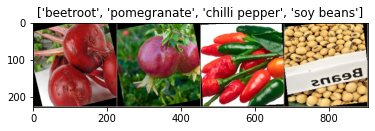

In [4]:
# Get a batch of training data
inputs, classes = next( iter( dataloaders[ "train" ] ) )

# Make a grid from batch
out = torchvision.utils.make_grid( inputs )

imshow( out, title=[ class_names[ x ] for x in classes ] )

# Model training

We will be training our model in epochs, where each epoch consists of two steps
- training step
- validation step

### Hyper parameter tuning

As our citerion, we will use `CrossEntropyLoss`, as we are trying to solve a classification problem with `n` classes and we want to minimize the entropy. For our optimizer, we use `SGD` as we obtained a better accuracy than with `Adam` and it was also mentioned in the original ResNet paper.

In [5]:
def train_model( model, criterion, optimizer, scheduler, epochs=25 ):
    since = time.time()

    best_model_wts = copy.deepcopy( model.state_dict() )
    best_acc = 0

    for epoch in range( epochs ):
        print( f"Epoch { epoch + 1 }/{ epochs }" )
        print( "----------" )
        
        for phase in [ "train", "validation" ]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0
            running_corrects = 0

            for inputs, labels in dataloaders[ phase ]:
                inputs = inputs.to( device )
                labels = labels.to( device )

                optimizer.zero_grad()
                
                with torch.set_grad_enabled( phase == "train" ):
                    outputs = model( inputs )
                    _, preds = torch.max( outputs, 1 )
                    loss = criterion( outputs, labels )

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum( preds == labels.data )
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[ phase ]
            epoch_acc = running_corrects.double() / dataset_sizes[ phase ]

            print(f"{ phase } Loss: { epoch_loss:.4f } Acc: { epoch_acc:.4f }")

            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy( model.state_dict() )

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in { time_elapsed // 60 }m { time_elapsed % 60 }s")
    print(f"Best val Acc: { best_acc }")

    # load the best model weights
    model.load_state_dict( best_model_wts )
    return model

In [6]:
def visualize_model( model, num_images=6 ):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate( dataloaders[ "validation" ] ):
            inputs = inputs.to( device )
            labels = labels.to( device )

            outputs = model( inputs )
            _, preds = torch.max( outputs, 1 )

            for j in range( inputs.size()[ 0 ] ):
                images_so_far += 1
                ax = plt.subplot( num_images // 2, 2, images_so_far )
                ax.axis('off')
                ax.set_title( f"predicted: { class_names[ preds[ j ] ] }" )
                imshow( inputs.cpu().data[ j ] )

                if images_so_far == num_images:
                    model.train( mode=was_training )
                    return
        
        model.train(mode=was_training)

We can visualize how accuracy and loss both on training set and validation set changes during indivivual epochs

<AxesSubplot:>

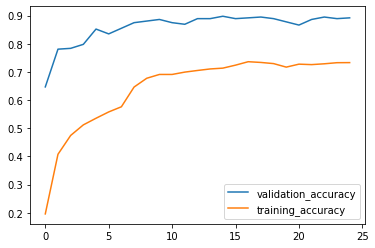

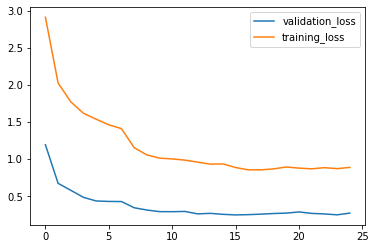

In [24]:
# these data are from google collab notebook I have been training my models on, as my notebook is not in the best shape,
# unfortunatelly they not represent the current model accuracy :)
from ml_utils import VALIDATION_INFO, TRAIN_INFO

EPOCHS = list( range( 1, len( VALIDATION_INFO ) + 1 ) )
validation_acc = list( map( lambda x: x[ 0 ], VALIDATION_INFO ) )
train_acc = list( map( lambda x: x[ 0 ], TRAIN_INFO ) )

acc = pd.DataFrame( columns=["validation_accuracy", "training_accuracy" ] )
acc.validation_accuracy = validation_acc
acc.training_accuracy = train_acc

acc.plot.line( y=["validation_accuracy", "training_accuracy"], )

validation_loss = list( map( lambda x: x[ 1 ], VALIDATION_INFO ) )
train_loss = list( map( lambda x: x[ 1 ], TRAIN_INFO ) )

loss = pd.DataFrame( columns=[ "validation_loss", "training_loss" ] )
loss.validation_loss = validation_loss
loss.training_loss = train_loss

loss.plot.line( y=["validation_loss", "training_loss"], )



In [34]:
model_ft = models.resnet18( pretrained=True )
num_ftrs = model_ft.fc.in_features

# model_ft.fc = nn.Linear( num_ftrs, len( class_names ) )

model_ft.fc = nn.Sequential(
                      nn.Linear(num_ftrs, len( class_names )), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear( len( class_names ), len(class_names)),                   
                      nn.LogSoftmax(dim=1))


model_ft = model_ft.to( device )

criterion = nn.CrossEntropyLoss()

# proposed in the paper, works the best
optimizer_ft = optim.SGD( model_ft.parameters(), lr=0.001, momentum=0.9 )

# criteration = nn.NLLLoss()
# optimizer_ft = optim.Adam(model_ft.parameters())

exp_lr_scheduler = lr_scheduler.StepLR( optimizer_ft, step_size=7, gamma=0.1 )

With this configuration, we have been able to achieve ~93% accuracy with only 25 epochs.

In [42]:
# model is already trained on our dataset, it takes ~70 minutes to train on mediocre cpu, therefore we just load it
model = torch.load( "models/resnet.pth", map_location=torch.device( "cpu" ) ) # if gpu is not available

# if you want to train the model, uncomment the following line
# model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

# 2.7 Model evaluation

To evaluate out model, we are going to look at the accuracy and then confusion matrix

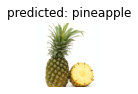

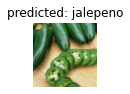

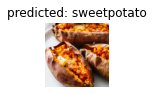

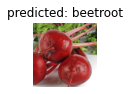

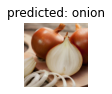

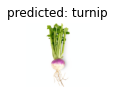

In [36]:
visualize_model( model )
plt.ioff()
plt.show()

Lets observe the model accuracy on `test` set

In [37]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()
    
check_accuracy( dataloaders[ "test" ], model )

Got 336 / 359 with accuracy 93.59


As can be seen, our model has ~93% accuracy on `test` dataset, which is quite nice. I hope it is due to the model being well trained :) and not because the overlap between test, train and validation dataset.

In [40]:
def plot_confusion_matrix( model ):
    confusion_matrix = np.zeros( ( len( class_names ), len( class_names ) ) )
    with torch.no_grad():
        for i, ( inputs, classes ) in enumerate( dataloaders[ "test" ] ):
            inputs = inputs.to( device )
            classes = classes.to( device )
            outputs = model( inputs )
            _, preds = torch.max( outputs, 1 )
            for t, p in zip( classes.view( -1 ), preds.view( -1 ) ):
                    confusion_matrix[ t.long(), p.long() ] += 1

    plt.figure(figsize=(15,10))

    df_cm = pd.DataFrame( confusion_matrix, index=class_names, columns=class_names ).astype( int )
    heatmap = sns.heatmap( df_cm, annot=True, fmt="d" )

    heatmap.yaxis.set_ticklabels( heatmap.yaxis.get_ticklabels(), rotation=0, ha="right", fontsize=15 )
    heatmap.xaxis.set_ticklabels( heatmap.xaxis.get_ticklabels(), rotation=45, ha="right", fontsize=15 )
    plt.ylabel( "True label" )
    plt.xlabel( "Predicted label" )

Lets take a look at what caused the accuracy loss in training dataset. Using confusion matrix, we can see classes which has been incorrectly labeled by our model.

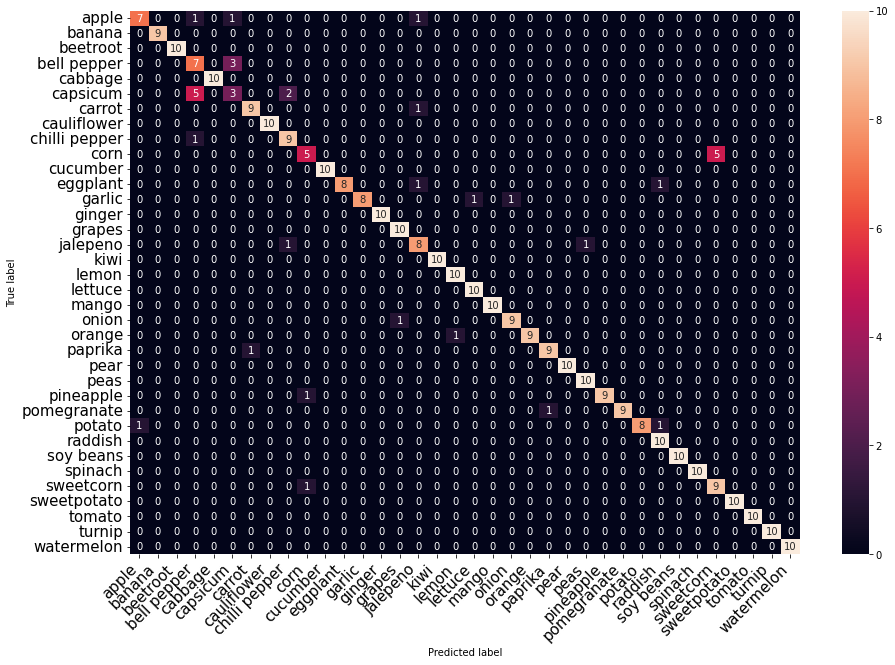

In [41]:
plot_confusion_matrix( model )

As can be seen, it is caused as `corn` being misclassified as `sweetcorn`. The question is, if this is even a problem. According to google

>  Corn or maize is a starchy food that comes in kernels on a cob tightly wrapped in a husk. Sweet corn, on the other hand, is a variety of corn that has a higher sugar content than other corn varieties.

In that case, I am not going to count as an error, as they are visually the same :)

The same goes for pepper and capsicum, I had to google what is the actual difference

# 2.8 Personal model summary

I am really happy about the model I trained, the accuracy is good and inconsistencies happens in classes which are very simmilar, and even after googling a lot, I did not find a suitable general answer how to solve this. I enjoyed the whole process, apart from working with `pytorch`, which I find quite user-unfriendly.